In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

In [2]:
# Training settings
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.01
MOMENTUM = 0.9
NO_CUDA = False
SEED = 1
CLASSES = 10
MODEL_PATH_ROOT = './weights/mnist10_cnn_liang2018'
MODEL_PATH = MODEL_PATH_ROOT + '.pth'

# MNIST mean and stdevs of training data by channel
CHANNEL_MEANS = (33.3184589445591/255,)
CHANNEL_STDS = (78.56747969985008/255,)

# Plot ROC and PR curves
PLOT_CHARTS = False

# ODIN parameters
TEMP = 1000.
NOISE_MAGNITUDE = 0.0

## Create network architecture

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        return x

## Training and Testing functions

In [4]:
from novelty.utils import Progbar


def train(model, device, train_loader, optimizer, epoch):
    progbar = Progbar(target=len(train_loader.dataset))

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        progbar.add(len(data), [("loss", loss.item())])
        
    

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    
    return test_loss, test_acc

## Initialize model and load MNIST

In [6]:
from novelty.utils import DATA_DIR
from src.wide_resnet import Wide_ResNet

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(DATA_DIR, 'mnist'), train=True, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(DATA_DIR, 'mnist'), train=False, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

# Create model instance
model = Net().to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

## Optimization loop

In [7]:
if os.path.exists(MODEL_PATH):
    # load previously trained model:
    model.load_state_dict(torch.load(MODEL_PATH))

else:
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print("Epoch:", epoch)
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    # save the model 
    torch.save(model.state_dict(), MODEL_PATH)

Epoch: 1
60000/60000 [==============================] - 2s 38us/step - loss: 0.5380
Test set: Average loss: 0.1088, Accuracy: 9674/10000 (97%)

Epoch: 2
60000/60000 [==============================] - 2s 38us/step - loss: 0.3419
Test set: Average loss: 0.0942, Accuracy: 9730/10000 (97%)

Epoch: 3
60000/60000 [==============================] - 2s 38us/step - loss: 0.3185
Test set: Average loss: 0.1026, Accuracy: 9700/10000 (97%)

Epoch: 4
60000/60000 [==============================] - 2s 37us/step - loss: 0.3067
Test set: Average loss: 0.0933, Accuracy: 9713/10000 (97%)

Epoch: 5
60000/60000 [==============================] - 2s 38us/step - loss: 0.3038
Test set: Average loss: 0.0895, Accuracy: 9722/10000 (97%)

Epoch: 6
60000/60000 [==============================] - 2s 38us/step - loss: 0.3095
Test set: Average loss: 0.0944, Accuracy: 9704/10000 (97%)

Epoch: 7
60000/60000 [==============================] - 2s 38us/step - loss: 0.3002
Test set: Average loss: 0.0904, Accuracy: 9723/10000

Process Process-54:
Process Process-53:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torchvision/datasets/mnis

KeyboardInterrupt: 

## ODIN prediction functions

In [8]:
from torch.autograd import Variable


def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_temp(model, data, device, temp=1000.):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs /= temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_novelty(model, data, device, temp=1000., noiseMagnitude=0.0012):
    model.eval()

    # Create a variable so we can get the gradients on the input
    inputs = Variable(data.to(device), requires_grad=True)

    # Get the predicted labels
    outputs = model(inputs)
    outputs = outputs / temp
    outputs = F.log_softmax(outputs, dim=1)

    # Calculate the perturbation to add to the input
    maxIndexTemp = torch.argmax(outputs, dim=1)
    labels = Variable(maxIndexTemp).to(device)
    loss = F.nll_loss(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient = torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2

    # Normalize the gradient to the same space of image
    for channel, (mean, std) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        gradient[0][channel] = (gradient[0][channel] - mean) / std

    # Add small perturbations to image
    # TODO, this is from the released code, but disagrees with paper I think
    tempInputs = torch.add(inputs.data, -noiseMagnitude, gradient)

    # Get new outputs after perturbations
    outputs = model(Variable(tempInputs))
    outputs = outputs / temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    outputs = F.softmax(outputs, dim=1)

    return outputs

## Evaluate method on outlier datasets

In [9]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result


def get_max_odin_outputs(data_loader, device, temp=1000., noiseMagnitude=0.0012):
    """Convenience function to get the max softmax values from the ODIN model in a Python array.
    
    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.
        
    device: object
        The CUDA device handle.
        
    temp: float, optional (default=1000.)
        The temp the model should use to do temperature scaling on the softmax outputs.
        
    noiseMagnitude: float, optional (default=0.0012)
        The epsilon value used to scale the input images according to the ODIN paper.
    """
    result = []
    
    for data, target in data_loader:
        # Using ODIN model
        p = predict_novelty(model, data, device, temp=temp, noiseMagnitude=noiseMagnitude)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [10]:
import pandas as pd

df = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'],
                  index=['letters', 'rot90', 'gaussian', 'uniform', 'not_mnist'])

df_odin = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'],
                  index=['letters', 'rot90', 'gaussian', 'uniform', 'not_mnist'])

### Process Inliers

In [11]:
num_inliers = len(test_loader.dataset)

# Get predictions on in-distribution images
mnist_model_maximums = get_max_model_outputs(test_loader, device)
mnist_odin_maximums = get_max_odin_outputs(test_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

### Fashion MNIST

In [12]:
directory = os.path.join(DATA_DIR, 'fashion_mnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
fashion_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(directory, train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_fashion = len(fashion_loader.dataset)

# Get predictions on in-distribution images
fashion_model_maximums = get_max_model_outputs(fashion_loader, device)
fashion_odin_maximums = get_max_odin_outputs(fashion_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

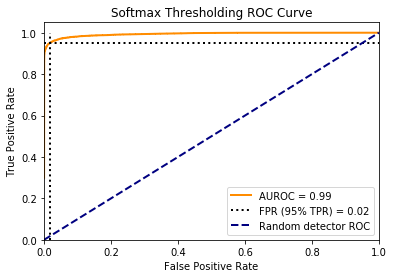

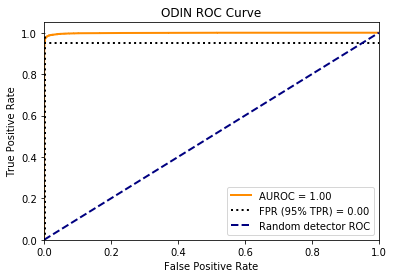

In [13]:
labels = [1] * num_inliers + [0] * num_fashion
predictions = mnist_model_maximums + fashion_model_maximums
predictions_odin = mnist_odin_maximums + fashion_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['fashion'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['fashion'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### EMNIST Letters

In [14]:
directory = os.path.join(DATA_DIR, 'emnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
emnist_loader = torch.utils.data.DataLoader(
        datasets.EMNIST(directory, "letters", train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_emnist = len(emnist_loader.dataset)

# Get predictions on in-distribution images
emnist_model_maximums = get_max_model_outputs(emnist_loader, device)
emnist_odin_maximums = get_max_odin_outputs(emnist_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

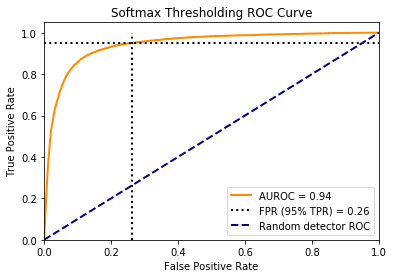

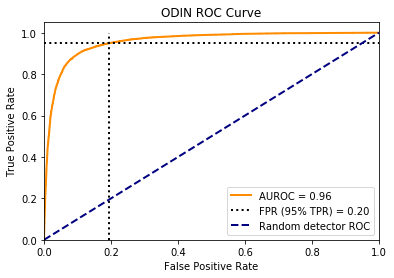

In [15]:
labels = [1] * num_inliers + [0] * num_emnist
predictions = mnist_model_maximums + emnist_model_maximums
predictions_odin = mnist_odin_maximums + emnist_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['letters'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['letters'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Not MNIST

In [16]:
directory = os.path.join(DATA_DIR, 'notmnist/notMNIST_small')

# Dataset transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
notmnist_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(directory, transform=transform),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_notmnist = len(notmnist_loader.dataset)

# Get predictions on in-distribution images
notmnist_model_maximums = get_max_model_outputs(notmnist_loader, device)
notmnist_odin_maximums = get_max_odin_outputs(notmnist_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

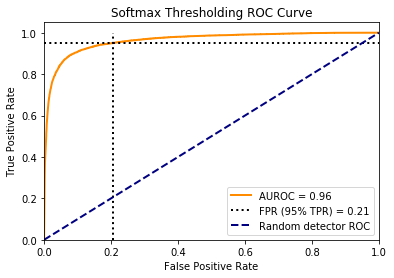

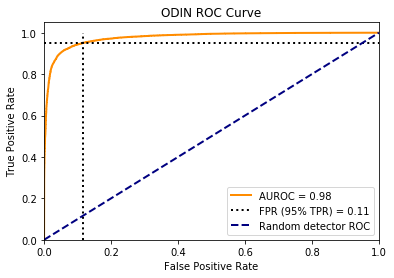

In [17]:
labels = [1] * num_inliers + [0] * num_notmnist
predictions = mnist_model_maximums + notmnist_model_maximums
predictions_odin = mnist_odin_maximums + notmnist_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['not_mnist'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['not_mnist'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Rotated 90 MNIST

In [18]:
directory = os.path.join(DATA_DIR, 'mnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.rotate(90)),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
rot90_loader = torch.utils.data.DataLoader(
        datasets.MNIST(directory, train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_rot90 = len(rot90_loader.dataset)

# Get predictions on in-distribution images
rot90_model_maximums = get_max_model_outputs(rot90_loader, device)
rot90_odin_maximums = get_max_odin_outputs(rot90_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

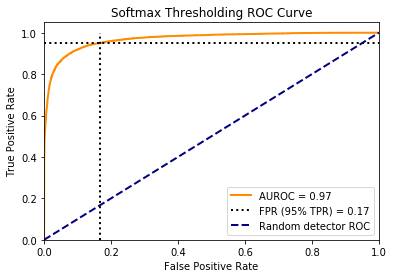

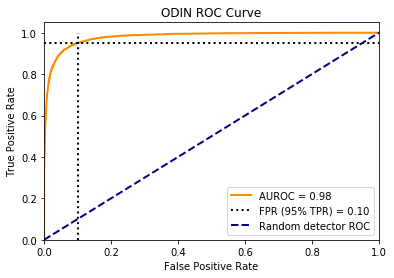

In [19]:
labels = [1] * num_inliers + [0] * num_rot90
predictions = mnist_model_maximums + rot90_model_maximums
predictions_odin = mnist_odin_maximums + rot90_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['rot90'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['rot90'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Gaussian Noise Dataset

In [20]:
from novelty.utils.datasets import GaussianNoiseDataset

gaussian_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor()
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
gaussian_loader = torch.utils.data.DataLoader(
    GaussianNoiseDataset((10000, 28, 28, 1), mean=0., std=1., transform=gaussian_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_gaussian = len(gaussian_loader.dataset)

# Get predictions on in-distribution images
gaussian_model_maximums = get_max_model_outputs(gaussian_loader, device)
gaussian_odin_maximums = get_max_odin_outputs(
    gaussian_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

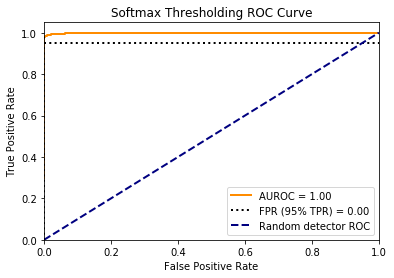

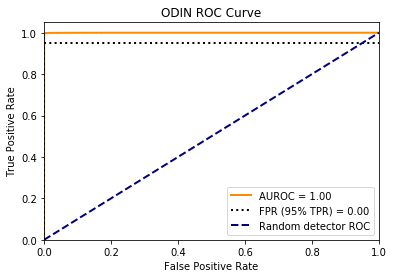

In [21]:
labels = [1] * num_inliers + [0] * num_gaussian
predictions = mnist_model_maximums + gaussian_model_maximums
predictions_odin = mnist_odin_maximums + gaussian_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['gaussian'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['gaussian'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Uniform Noise Dataset

In [22]:
from novelty.utils.datasets import UniformNoiseDataset
import math

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
uniform_loader = torch.utils.data.DataLoader(
    UniformNoiseDataset((10000, 28, 28, 1), low=-math.sqrt(3.), high=math.sqrt(3.), transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_uniform = len(uniform_loader.dataset)

# Get predictions on in-distribution images
uniform_model_maximums = get_max_model_outputs(uniform_loader, device)
uniform_odin_maximums = get_max_odin_outputs(
    uniform_loader, device, temp=TEMP, noiseMagnitude=NOISE_MAGNITUDE)

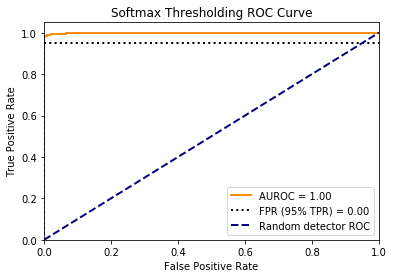

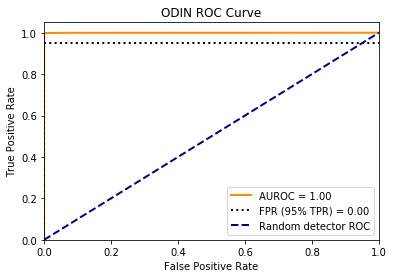

In [23]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = mnist_model_maximums + uniform_model_maximums
predictions_odin = mnist_odin_maximums + uniform_odin_maximums

stats = get_summary_statistics(predictions, labels)
df.loc['uniform'] = pd.Series(stats)

stats_odin = get_summary_statistics(predictions_odin, labels)
df_odin.loc['uniform'] = pd.Series(stats_odin)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

In [32]:
df.to_pickle('./results/mnist10_cnn_liang2018.pkl')
df_odin.to_pickle('./results/mnist10_cnn_odin_liang2018.pkl')

In [33]:
df

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
letters,0.941468,0.887627,0.968114,0.263125,0.156563
rot90,0.969046,0.972297,0.965594,0.165700,0.107800
gaussian,0.999224,0.999295,0.999178,0.000000,0.023050
uniform,0.999246,0.999312,0.999203,0.000100,0.023000
not_mnist,0.962084,0.941435,0.976269,0.206259,0.128130
fashion,0.993497,0.994630,0.992530,0.017300,0.033600


In [34]:
df_odin

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
letters,0.956622,0.911237,0.977216,0.195288,0.122644
rot90,0.979599,0.980215,0.979200,0.100800,0.075400
gaussian,0.999913,0.999920,0.999910,0.000000,0.014800
uniform,0.999915,0.999921,0.999911,0.000000,0.014800
not_mnist,0.976553,0.962922,0.985950,0.114826,0.082413
fashion,0.998599,0.998787,0.998434,0.001400,0.024350
